# Coursework 1: Gradient Descent (27 Points)
### Autograding
Part 1 of this coursework is autograded. This notebook comes with embedded tests which will verify that your implementations provide outputs with the appropriate types and shapes required for our hidden tests. You can run these same public tests through [LabTS](https://teaching.doc.ic.ac.uk/labts) when you have finished your work, to check that we get the same results when running these public tests.

Hidden tests will be ran after the submission deadline, and cannot be accessed. They mostly check that you didn't cheat by using external functions, or that your implementations generate the correct answers for a few different (sensible) inputs.

### Setup


In [1]:
%pip install -q otter-grader==4.1.0 numpy pandoc seaborn autograd memory-profiler graphviz

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Initialization Cell
%matplotlib inline
import otter
grader = otter.Notebook("mml_cw_1.ipynb")
import matplotlib.pyplot as plt # DO NOT use %matplotlib inline in the notebook
import numpy as np
rng_seed = 90

---
## Part 1 - Differentiation & Gradient Descent (16 points)

In this question, we define the following constants:

$$\boldsymbol{B}=\left(\begin{array}{cc}
4 & -2 \\
-2 & 4
\end{array}\right), \quad \boldsymbol{a}=\left(\begin{array}{l}
0 \\
1
\end{array}\right), \quad \boldsymbol{b}=\left(\begin{array}{c}
-2 \\
1
\end{array}\right)$$

We define also the following functions, which are all $\mathbb{R}^2 \rightarrow \mathbb{R}$
$$
\begin{aligned}
&f_1(\boldsymbol{x})=\boldsymbol{x}^T \boldsymbol{B} \boldsymbol{x}-\boldsymbol{x}^T \boldsymbol{x}+\boldsymbol{a}^T \boldsymbol{x}-\boldsymbol{b}^T \boldsymbol{x} \\
&f_2(\boldsymbol{x})=\cos \left((\boldsymbol{x}-\boldsymbol{b})^T(\boldsymbol{x}-\boldsymbol{b})\right)+(\boldsymbol{x}-\boldsymbol{a})^T \boldsymbol{B}(\boldsymbol{x}-\boldsymbol{a}) \\
&f_3(\boldsymbol{x})=1-\left(\exp \left(-(\boldsymbol{x}-\boldsymbol{a})^T(\boldsymbol{x}-\boldsymbol{a})\right)+\exp \left(-(\boldsymbol{x}-\boldsymbol{b})^T \boldsymbol{B}(\boldsymbol{x}-\boldsymbol{b})\right)-\frac{1}{10} \log \left|\frac{1}{100} \boldsymbol{I}+\boldsymbol{x} \boldsymbol{x}^T\right|\right)
\end{aligned}
$$
Implementations of these functions are provided below.

Throughout this exercise, we remain consistent in our convention of using row vectors for our gradients $\left( \textnormal{i.e. } \frac{\partial f_1}{\partial x}, \frac{\partial f_2}{\partial x}, \frac{\partial f_3}{\partial x} \in \mathbb{R}^{1 \times 2} \right )$. 


In [2]:
# Defined constants
B = np.array([[4, -2], [-2, 4]])
a = np.array([[0], [1]])
b = np.array([[-2], [1]])

def f1(x):
    """ Function f1 taking input x with shape (2, 1) """
    return float(x.T @ B @ x - x.T @ x + a.T @ x - b.T @ x)

def f2(x):
    """ Function f2 taking input x with shape (2, 1) """
    return float(np.cos((x - b).T @ (x - b)) + (x - a).T @ B @ (x - a))

def f3(x):
    """ Function f3 taking input x with shape (2, 1) """
    return float(1 - (np.exp(-(x - a).T @ (x - a)) + \
                 np.exp(-(x - b).T @ B @ (x - b)) - \
                 (1/10.) * np.log(np.linalg.det((1/100.) * np.identity(2) + x @ x.T))))

---
### Question 1 - Checking for the existence of Minima (2 Points)
Complete the function ```f1_check_minimum(B, a, b)``` that checks whether function $f_1$ has a minimum given certain values of **a**, **b** and diagonal **B**.

Hint: you may not need to use all three gradients

In [3]:
def f1_check_minimum(B, a, b):
    """ Write a function that returns True if function f1 has a minimum for variables B, a and b, and returns False otherwise.
        Hint: it may not be required to use all B, a and b. """
    
    #Existence condition of the extremum 
    extremum = B[0][0] != 1 and B[1][1] != 1
    
    #Calculation of the Hessian matrix and verification of the (positive) eigenvalues
    if extremum == True:
        hessian_matrix = np.array([[2*(B[0][0]-1), B[0][1] + B[1][1]], [B[0][1] + B[1][1],2*(B[1][1]-1)]])
        eigenvalues = np.linalg.eigvals(hessian_matrix)
        check_minimum = eigenvalues[0] > 0 and eigenvalues[1] > 0               
    
    return check_minimum

In [4]:
grader.check("1. Function 1 Minima Check")

1. Function 1 Minima Check results: All test cases passed!
1. Function 1 Minima Check - 1 message: F1 Minimum Check (with minimum) Test Passed

---
### Question 2 - Calculating Gradients (6 Points)
#### Question 2.a - Method of Finite Differences (2 Points)
Remember (animation in lectures) that a gradient is found by taking
$$ \lim _{\Delta x \rightarrow 0} \frac{f(x+\Delta x)-f(x)}{\Delta x} $$
We can approximate this by calculating the expression for a small but finite $\Delta x$ along each dimension, which
is known as the _finite-differences_ approximation.

Complete the function ```grad_fn(fn, x)``` such that it returns the gradients for any function ```fn``` at a point **x** using the method of finite differences. Use a delta of $1\times 10^{-5}$.

_The function should take a columnar numpy (2, 1) vector for ‘x’ as input, and output a
numpy (1, 2) row vector for the gradient._

In [5]:
def grad_fd(fn, x, delta=1e-5):
    """ General function that calculates gradient of some 2d function at point x,
        using finite-differences.

    Inputs:
            fn: Function taking input x and returns a scalar
            x: Numpy vector of shape (2, 1)
            delta: Finite-difference delta (epsilon) used for approximation

    Returns: Approximated gradient at point x, in shape (1, 2)
    """
    
    #Delta vector and partial derivative w.r.t x1
    delta_x1 = np.array([[delta],[0]])
    dfdx1 = (fn(x + delta_x1) - fn(x))/delta
    
    #Delta vector and partial derivative w.r.t x2
    delta_x2 = np.array([[0],[delta]])   
    dfdx2 = (fn(x + delta_x2) - fn(x))/delta
    
    #Gradient vector
    dfdx = np.array([[dfdx1, dfdx2]]) 
    
    return dfdx

In [6]:
grader.check("2.a Method of Finite Differences")

2.a Method of Finite Differences results: All test cases passed!
2.a Method of Finite Differences - 1 message: Finite Differences on f1 Test Passed
2.a Method of Finite Differences - 2 message: Finite Differences on f2 Test Passed

---
#### Question 2.b - Analytical Gradients (4 Points)
Complete the functions ```f1_grad(x)```, ```f2_grad(x)``` and ```f3_grad(x)``` that return
gradients of f1, f2 and f3, using your own derivations.

_The functions should take a columnar numpy (2, 1) vector for **x** as input, and output a
numpy (1, 2) row vector for the gradient_

In [7]:
def f1_grad_exact(x):
    """ Return gradient of f1, exactly derived by hand """
    
    #We know B is symmetric so we can write 2 * x.T @ B. If B wasn't symmetric we should write x.T @ (B + B.T)
    gradient = 2 * x.T @ B - 2 * x.T + a.T - b.T
    
    return gradient

In [8]:
grader.check("Q2.b.i Gradients of the Functions - f1")

Q2.b.i Gradients of the Functions - f1 results: All test cases passed!
Q2.b.i Gradients of the Functions - f1 - 1 message: Exact Gradients of f1 Test Passed

In [9]:
def f2_grad_exact(x):
    """ Return gradient of f2, exactly derived by hand """
    
    u = x - a
    v = x - b
    
    #We know B is symmetric so we can write 2 * x.T @ B. If B wasn't symmetric we should write x.T @ (B + B.T)
    gradient = -2 * v.T * np.sin(v.T @ v) + 2 * u.T @ B
    
    return gradient

In [10]:
grader.check("Q2.b.ii Gradients of the Functions - f2")

Q2.b.ii Gradients of the Functions - f2 results: All test cases passed!
Q2.b.ii Gradients of the Functions - f2 - 1 message: Exact Gradients of f2 Test Passed

In [11]:
def f3_grad_exact(x):
    """ Return gradient of f3, exactly derived by hand """
    
    dlogdx = np.array([2*x[0,0] / (x[0,0]**2 + x[1,0]**2 + 1/100) , 2*x[1,0] / (x[0,0]**2 + x[1,0]**2 + 1/100)])
    
    u = x - a
    v = x - b
    
    #We know B is symmetric so we can write 2 * x.T @ B. If B wasn't symmetric we should write x.T @ (B + B.T)
    gradient = - ( -2 * u.T * np.exp(-u.T @ u) - 2 * v.T @ B * np.exp(-v.T @ B @ v) - (1/10) * dlogdx)
    
    return gradient

In [12]:
grader.check("Q2.b.iii Gradients of the Functions - f3")

Q2.b.iii Gradients of the Functions - f3 results: All test cases passed!
Q2.b.iii Gradients of the Functions - f3 - 1 message: Exact Gradients of f2 Test Passed

In [13]:
# (optional) It's a good idea to test whether your analytical gradients 
# _closely_ match those given by finite differencing

#Choosing random values for our x vector
x1 = 1.9
x2 = 8.4
x = np.array([[x1],[x2]])

print('Finite differencing method with f1 :', grad_fd(f1, x, delta=1e-5))
print('Analytical gradient with f1 :', f1_grad_exact(x))
print('Do we have the same results between the two methods?', np.round(grad_fd(f1, x, delta=1e-5),1) == np.round(f1_grad_exact(x),1))
print('\n')

print('Finite differencing method with f2 :', grad_fd(f2, x, delta=1e-5))
print('Analytical gradient with f2 :', f2_grad_exact(x))
print('Do we have the same results between the two methods?', np.round(grad_fd(f2, x, delta=1e-5),1) == np.round(f2_grad_exact(x),1))
print('\n')

print('Finite differencing method with f3 :', grad_fd(f3, x, delta=1e-5))
print('Analytical gradient with f3 :', f3_grad_exact(x))
print('Do we have the same results between the two methods?', np.round(grad_fd(f3, x, delta=1e-5),1) == np.round(f3_grad_exact(x),1))

Finite differencing method with f1 : [[-20.19997  42.80003]]
Analytical gradient with f1 : [[-20.2  42.8]]
Do we have the same results between the two methods? [[ True  True]]


Finite differencing method with f2 : [[-20.28562387  40.43203696]]
Analytical gradient with f2 : [[-20.2854567   40.43272319]]
Do we have the same results between the two methods? [[ True  True]]


Finite differencing method with f3 : [[0.00512269 0.0226476 ]]
Analytical gradient with f3 : [[0.00512267 0.02264761]]
Do we have the same results between the two methods? [[ True  True]]


---
### Question 3 - Gradient Descent (8 Points)
Use your gradients to implement a gradient descent algorithm **with 50 iterations**
to find a local minimum for both f2 and f3, by finishing the function grad descent(fn,
grad fn).

For visualizing (and debugging) your gradient descent function, we provide some plotting code. This is contained in the cell below, so be sure to exectue it. You can use this function on f1 by passing in the other functions, for example: ```plot_grad_descent(f1, f1_grad_exact, gradient_descent)``` once you have completed the ```gradient_descent(fn, grad_fn)``` function. You can also pass in ```xrange=(x_min, x_max)``` and likewise for ```yrange``` to adjust the plotted region.

In [14]:
# Provide function for plotting gradient descent
import matplotlib.pyplot as plt
def plot_grad_descent(fn, fn_grad, gradient_descent_fn, xrange=(-1, 1), yrange=(-1,1), **kwargs):
    title = 'Plotting function #'+ fn_grad.__name__.split('_')[0][-1]
    # Define plotting range for x- and y- axis.
    x1min, x1max = xrange
    x2min, x2max = yrange

    # Evaluate function everywhere within the defined range for the contour plot
    x1 = np.linspace(x1min, x1max, 100)
    x2 = np.linspace(x2min, x2max, 100)

    X1, X2 = np.meshgrid(x1, x2)

    Y = [fn(np.array([[p1], [p2]])) for p1, p2 in zip(X1.flatten(), X2.flatten())]
    Y = np.array(Y).reshape(X1.shape)

    # Plot contour
    plt.title(title)
    plt.xlim(x1min, x1max)
    plt.ylim(x2min, x2max)
    plt.contourf(X1, X2, Y)
    plt.colorbar()

    # Plot gradient descent trajectory
    trajectory, found_minimum, found_minimum_value = gradient_descent_fn(fn, fn_grad, **kwargs)

    p1, p2 = zip(*trajectory)
    plt.plot(p1, p2, '.-', color='red')

#### Question 3.a - Implementing Gradient Descent (4 Points)
Complete the ```gradient_descent``` function below.

In [15]:
def gradient_descent(fn, grad_fn, start_x=4.0, start_y=4.0, lr=0.001, n_steps=50, silent=False):
    """ Function that performs gradient descent.

    Inputs: 
        - fn: Function to minimize
        - grad_fn: Function that returns gradient of the function to minimize
        - start_loc: Initial location
        - lr: The learning rate
        - n_steps: Number of steps
        - silent: prevent print statement (for testing)

    Returns: Tuple containing:
        - trajectory of found points: a list containing numpy (2, 1) column vectors
        - final minimum point: a numpy (2, 1) column vector
        - the value at the minimum: float
    """

    start_loc = np.array([[start_x], [start_y]])
    trajectory = [start_loc]
    lowest_value = np.inf
        
    for step in range(1,n_steps+1):
        
        #Calculation of the new position (thus the two coordinates)
        new_x1_loc = start_loc[0] - lr * grad_fn(start_loc)[0][0]
        new_x2_loc = start_loc[1] - lr * grad_fn(start_loc)[0][1]
        
        #Updating our location overtime
        start_loc = np.array([[new_x1_loc[0]], [new_x2_loc[0]]])  

        #Stocking all the positions and calculating the value at this precise new position
        trajectory.append(start_loc)        
        new_value = fn(trajectory[step])
        
        #Verification of the lowest value which equivalent to the last one (if our algorithm converges)
        if new_value < lowest_value:
            lowest_value = new_value
            found_minimum_value = lowest_value
            found_minimum_loc = start_loc

    if not silent:
        print(f"Gradient descent found minimum value {found_minimum_value:.2f} at {found_minimum_loc.T}^T")
        
    return trajectory, found_minimum_loc, found_minimum_value

Gradient descent found minimum value 8.37 at [[1.52521573 1.70982674]]^T


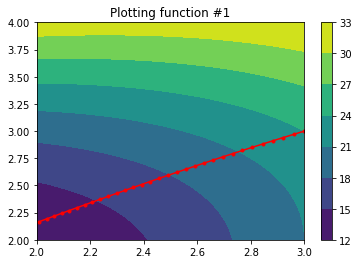

In [16]:
# Here we'll use the plotting function and specify custom starting points and plotting ranges
plot_grad_descent(f1, f1_grad_exact, gradient_descent,
                  xrange=(2, 3), yrange=(2, 4),
                  start_x=3, start_y=3, lr=0.005
)

**Note** The last two tests should be run after the first one

In [17]:
grader.check("Gradient Descent")

Gradient Descent results: All test cases passed!
Gradient Descent - 1 message: Gradient Descent Trajectory Test Passed
Gradient Descent - 2 message: Gradient Descent Minimum Location Test Passed
Gradient Descent - 3 message: Gradient Descent Minimum Value Test Passed

#### Question 3.b - Choosing Good Initializations (2 Points)


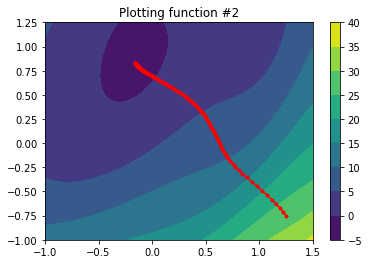

In [18]:
# Here we'll use the plotting function and specify custom starting points and plotting ranges
# For F2 
f2_start_x = 1.25
f2_start_y = -0.75
f2_lr = 0.0025
f2_n_steps = 100

plot_grad_descent(f2, f2_grad_exact, gradient_descent,
                  xrange=(-1, 1.5), yrange=(-1, 1.25),
                  start_x=f2_start_x, start_y=f2_start_y, lr=f2_lr, n_steps=f2_n_steps, silent=True
)

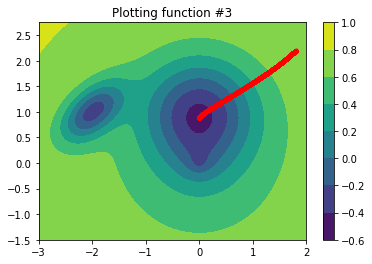

In [19]:
# For F3 
f3_start_x = 1.8
f3_start_y = 2.2
f3_lr = 0.001
f3_n_steps = 10000

plot_grad_descent(f3, f3_grad_exact, gradient_descent,
                  xrange=(-3, 2), yrange=(-1.5, 2.75),
                  start_x=f3_start_x, start_y=f3_start_y, lr=f3_lr, n_steps=f3_n_steps, silent=True
)

#### Question 3.c - Failure to Converge (2 Points)
Find an example of diverging behaviour and describe three ways that we can encourage convergence in practice.

<!-- BEGIN QUESTION -->



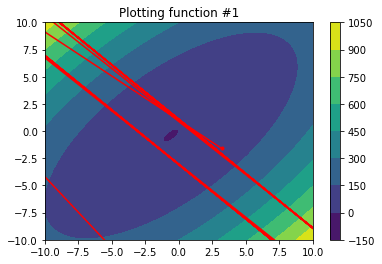

In [20]:
f1_start_x = 3.2
f1_start_y = -1.6
f1_lr = 1
f1_n_steps = 100

plot_grad_descent(f1, f1_grad_exact, gradient_descent,
                  xrange=(-10, 10), yrange=(-10, 10),
                  start_x=f1_start_x, start_y=f1_start_y, lr=f1_lr, n_steps=f1_n_steps, silent=True
)

**Answer:**

The graph above shows a convergence problem for our gradient descent algorithm with the imposed parameters. The value keeps oscillating and growing rather than getting closer and converging to the minimum. Moreover, if we take a higher number of steps, the IDE returns the following problems: 

* **RuntimeWarning: overflow encountered in matmul return float(x.T @ B @ x - x.T @ x + a.T @ x - b.T @ x)**

* **RuntimeWarning: invalid value encountered in subtract return float(x.T @ B @ x - x.T @ x + a.T @ x - b.T @ x)**

* **RuntimeWarning: invalid value encountered in matmul return float(x.T @ B @ x - x.T @ x + a.T @ x - b.T @ x)**

In order to ensure convergence in practice, the following conditions should be met as far as possible: 

* **1. Find a relevant starting point.** To do so, we can try several starting points and see how they behave in relation to the graph and our model and parameters.

* **2. Find a relevant learning rate which must be positive otherwise we change the problem.** Indeed, instead of having a descending gradient, we will have an ascending gradient, which is not suitable for finding a minimum. A low learning rate will theoretically allow our gradient descent to converge, but it will be slow and we must ensure that we have a sufficient number of steps to converge to the minimum. On the contrary, a high learning rate may fail to converge, or even diverge. Alternatively, a non-fixed learning rate that varies over time can be proposed.

* **3. Find a relevant number of steps.** We can take a large number of steps and reduce them until we find a "low" but suitable value to ensure convergence.

Finally, we can also propose **a second stopping condition** in addition to the number of steps, such as **a minimum epsilon value that the gradient should seek to reach**.

<!-- END QUESTION -->

---
## Part 2 - Automatic Differentation (11 Points)

In the previous part you saw how you can implement gradient descent to optimize functions by using either approximate or analytical gradients. Luckily for us, there are frameworks which implement derivatives for most functions we might typically care about, and which allow us to differentiate through arbitrary compositions of these functions by using **Automatic Differentiation** (autodiff). Indeed, you may already have encountered frameworks such as PyTorch, TensorFlow or Jax which have robust autodiff implementations.

In this part we'll demonstrate the power of autodiff through the [autograd](https://github.com/HIPS/autograd) library which provides a clean interface for automatically differentiating over numpy functions. Let's start by taking a look at the syntax for computing gradients in autograd:

In [21]:
from autograd import grad 
import autograd.numpy as np # Autograd wraps numpy to support automatic differentiation
# Note that particularly niche numpy functions may not be supported by autograd

# Consider the sum of squares function
def xsq(x): 
    return np.sum(x**2)

# We know the gradient of this! 
def our_grad_of_xsq(x):
    return 2*x

x = np.random.rand(4)

# We can wrap functions with grad to get the gradient function
autograd_grad_of_xsq = grad(xsq, 0) # 0 => want the gradient with respect to the first argument

# Evaluate gradients at x and check that they're the same
print(autograd_grad_of_xsq(x))
print(our_grad_of_xsq(x))

[0.14085257 1.94414724 0.79917082 1.60023341]
[0.14085257 1.94414724 0.79917082 1.60023341]


---
### Question 4 - Squared Distances and Automatic Differentiation
Although we can see that autograd is perfectly capable of computing derivatives by itself, there may be instances where the derivative of a non-elementary function is analytically *more efficient* than the composition of the gradients of its components. This means that we are better off telling autograd to use our derivate when it performs automatic differentation (sometimes we might also use esoteric functions which don't even have an existing derivate, in which case we are forced to provide one).

#### Question 4.a - Forward Pass of the Squared Distances function (1 Point)
In particular, we'll consider the gradient of 
$$ s = \vec{p}^T \mathbf{D} \vec{q}, $$
with respect to $\vec{z}$, where $\vec{p}$ and $\vec{q}$ are constants, and $\mathbf{D}$ is the matrix of squared distances between elements of $\vec{z}$:
$$ D_{ij} = \exp(-(z_i - z_j)^2). $$

Get warmed up by implementing the the function ```sq_dist_fwd(p,q,x)``` which computes $\vec{s}$.

In [22]:
import autograd.numpy as np
from autograd import grad
np.random.seed(0)

# Naive solution
p = np.random.rand(4)
q = np.random.rand(4) 

def sq_dist_fwd(p,q,x):
    """ Compute the inner product of p and q, projected through a matrix consisting of the 
        squared distance between elements of a variable x. All vectors are length x.shape[0].
        To be compatible with autograd, we need to avoid using assignments on array indices 
    """
    
    N = x.shape[0]
    assert N % 2 == 0 # We expect even numbers of elements
    assert x.shape[0] == p.shape[0] == q.shape[0]
    
    """
    Calculating D with a loop over the matrix using array indices
    """
    
    #I initialize the matix of squared distancess between elements of x (z)
    #D = np.zeros((x.shape[0], x.shape[0])) 
    
    #Loop over the matrix to compute each element
    #for i in range(N):
        #for j in range(N):
            #D[i][j] = np.exp(-(x[i]-x[j])**2)
    
    """
    Calculating D without using array indices to be compatible with autograd
    """
    
    #Here z directly represents x whereas at the end of the coursework it will represent a function of x
    z = np.array([x]) 
    
    #Broadcasting stretches both arrays 
    D = np.exp(-(z - z.T)**2) 
    
    #Definition of s
    out = p.T @ D @ q
    
    return out 

In [23]:
#Testing the function for random values
x = np.random.rand(4)
sq_dist_fwd(p,q,x)

5.278563706100499

In [24]:
grader.check("Q4.a Squared Distance Function")

Q4.a Squared Distance Function results: All test cases passed!
Q4.a Squared Distance Function - 1 message: Squared Distance Function Output Shape Test Passed

#### Question 4.b - Analytical Derivate of Squared Distances (2 Points)
In order to override autograd's gradient for our squared distance function, we need to derive it ourselves - compute the derivate:
$$\frac{\partial \vec{s}}{\partial \vec{z}} =\sum_{i j} a_i b_j \frac{\partial D_{i j}}{\partial \vec{z}}, $$
with respect to one element of $\vec{z}$.


<!-- BEGIN QUESTION -->

**Answer:**

$$
\frac{\partial \vec{s}}{\partial \vec{z_n}} =
\begin{cases}
2\sum_{i j} a_i b_j (z_j - z_i) exp(-(z_i-z_j)^2) & \text{if $n = i$} \\
2\sum_{i j} a_i b_j (z_i - z_j) exp(-(z_i-z_j)^2) & \text{if $n = j$} \\
0 & \text{otherwise ($n \neq i,j)$} 
\end{cases}
$$

<!-- END QUESTION -->

#### Question 4.c - Implement the Derivative (2 Points)
With the analytical derivate in hand, complete the ```sq_dist_grad_elem(a, b, x, z)``` function which computes the gradient with respect to the $n^{th}$ dimension of $\vec{z}$ and the corresponding function ```sq_dist_grad``` which computes the gradient vector.



In [25]:
# Implement your analytical gradients here

# Gradient w.r.t nth element of z
# NOTE - you can ignore this function if you prefer to vectorize your implementation
def sq_dist_grad_elem(p, q, z, n):
    
    #Initializing our dimensions and sum
    shape = z.shape[0]
    grad_sk = 0
    
    #Looping over the matrix to compute each element depending on the three cases presented above
    for i in range(shape):
        for j in range(shape):
            if i == n :
                grad_sk = grad_sk + p[i] * q[j] * (2 * (z[j]-z[i]) * np.exp(-(z[i]-z[j])**2))
            elif j == n : 
                grad_sk = grad_sk + p[i] * q[j] * (2 * (z[i]-z[j]) * np.exp(-(z[i]-z[j])**2))
            else : 
                grad_sk = grad_sk + 0
    
    return grad_sk

# Gradient w.r.t the whole vector z
def sq_dist_grad(p, q, z):
    
    #Initializing our dimensions and array
    shape = z.shape[0]
    grad_s = np.zeros((shape))
    
    #Computing all elements of our gradient of s
    for n in range(shape):
        grad_s[n] = sq_dist_grad_elem(p,q,z,n)
        
    return grad_s    

In [26]:
grader.check("Q4.c Squared Distance Function Gradients")

Q4.c Squared Distance Function Gradients results: All test cases passed!
Q4.c Squared Distance Function Gradients - 1 message: Squared Distance Gradient Function Shape Test Passed

In [27]:
# (optional) It is a good idea to check the output of your gradient
# function against the one generated by autograd

#Selecting random values
p = np.random.rand(4)
q = np.random.rand(4)
z = np.random.rand(4)

#Our functions
autograd_grad_of_xsq = grad(sq_dist_fwd, 2)(p,q,z) # 2 => want the gradient with respect to the 3rd argument
hand_grad = sq_dist_grad(p, q, z)

print('Output of the gradient generated with the analytical derivate  :', hand_grad)
print('Output of the gradient generated with autograd :', autograd_grad_of_xsq)      
print('Do we have the same results between the two methods?', np.round(hand_grad,5) == np.round(autograd_grad_of_xsq,5))

Output of the gradient generated with the analytical derivate  : [-0.79128396 -0.902273    1.10949745  0.58405951]
Output of the gradient generated with autograd : [-0.79128396 -0.902273    1.10949745  0.58405951]
Do we have the same results between the two methods? [ True  True  True  True]


#### Question 4.d - Automatic Differentiation (2 Points)

Armed with our superior gradient function for the sum of squared distances, let's tell autograd to use it, and convince ourselves that all our hardwork was worthwhile!

First, let's compare memory usage to check whether our implementation actually requires less memory:

In [28]:
%load_ext memory_profiler
p,q,z = np.random.randn(200), np.random.randn(200), np.random.randn(200)
print('Ours: ', end=' ') #Analytical
%memit sq_dist_grad(p,q,z)
print('Theirs:', end=' ') #Autograd
%memit grad(sq_dist_fwd, 2)(p,q,z) 

Ours:  peak memory: 151.41 MiB, increment: 0.23 MiB
Theirs: peak memory: 153.57 MiB, increment: 2.15 MiB


You should see that our implementation of the gradient function requires considerably less memory than the one autograd provides by using autodiff. 

Now let's tell autograd to use our analytically derived gradient function when computing autodiff for a more complicated function:
$$ \vec{y} = \vec{s} = \vec{p}^T \mathbf{D}(\vec{z}) \vec{q}, \quad \text{and} \quad \vec{z} = 3\sin{x}+5$$

We'll start by revisiting our toy example of $x^2$.

In [29]:
from autograd.extend import primitive, defvjp
# First we'll consider the x squared example again

@primitive # This tells autograd we will define the gradient ourselves
def xsq(x): 
    return np.sum(x**2)

# Here's an example of how to define a custom backward pass gradient function
def xsq_vjp(ans, x):
    """ This should return a function which takes the gradient (g) of the SUBSEQUENT function
        and combines it with the gradient of the function we're differentiating 
        (i.e. propagating the accumulated gradient backwards through the graph)
    """
    print('We are constructing the computational graph')

    def xsq_vjp_inner(g):
        print('We are auto differentiating')
        print(f'gradient in was {g}, answer in was {ans}\n')
        return 2*x*g 
    
    print('The gradient function has been stored in the graph \n')
    return xsq_vjp_inner

defvjp(xsq, xsq_vjp)

print('Gradient out: ', grad(xsq)(np.array([1., 2., 3.])))

We are constructing the computational graph
The gradient function has been stored in the graph 

We are auto differentiating
gradient in was 1.0, answer in was 14.0

Gradient out:  [2. 4. 6.]


Now let's apply the same idea to our squared distance function

In [30]:
from functools import partial 
# We'll overwrite the naive solution with a primitive
# to make life easier let's fix p and q with "partial"
p,q,z = np.random.randn(4), np.random.randn(4), np.random.randn(4)
sq_dist_fwd_wrapped = partial(sq_dist_fwd, p, q)
sq_dist_grad_wrapped = partial(sq_dist_grad, p, q)

@primitive # Tell autograd we'll use a custom gradient for sq_dist
def sq_dist(z):
    # Function returns the squared distance with p,q fixed
    
    return sq_dist_fwd_wrapped(z) 

def sq_dist_vjp(ans, z): 
    # Return a function which takes the gradient of the SUBSEQUENT function
    # and combines it with the gradient of sq_dist
    
    def sq_dist_vjp_inner(g):
        
        return sq_dist_grad_wrapped(z)*g #Chain rule
    
    return sq_dist_vjp_inner

defvjp(sq_dist, sq_dist_vjp) # Assign backward gradient sq_dist_vjp to sq_dist function

In [31]:
grader.check("Q4.d Squared Distance Autodiff")

Q4.d Squared Distance Autodiff results: All test cases passed!
Q4.d Squared Distance Autodiff - 1 message: Squared Distance Autodiff Value Test Passed

#### Question 4.e - Understanding Autodiff (4 Points)
Now that we've seen how to define custom gradients for autodiff, let's double check our understanding:
1. Draw the computational graph for the ```complete_function(x)```, defined below
2. Estimate the Memory and Time complexity of the autodiff gradient calculation, and compare this to ours

In [32]:
# consider the function
x = np.random.rand(4)
z = np.sin(x)*3 + 5
y = sq_dist(z)

# we can compute the gradient of y with respect to x using autograd
def complete_function(x):
    z = np.sin(x)*3 + 5
    return sq_dist(z) # This will now use our gradient function!

grad(complete_function)(x)

array([ 0.21285313, -2.3276132 , -0.18500383,  2.29914173])

<!-- BEGIN QUESTION -->



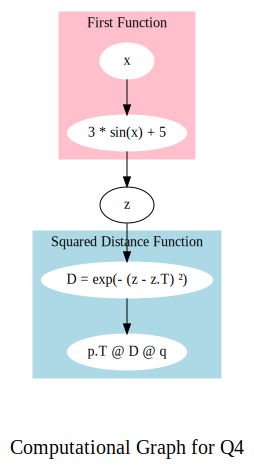

In [33]:
"""Question 4.e.i - Create a (rough) computational graph for the function
   NOTE the following:
    1. You do not have to use graphviz (example given here) - you can 
       use tools such as https://draw.io or https://www.lucidchart.com
       and embed the results into this notebook (or upload them and provide
       a link) - just be sure to check that they appear in the LabTS output
       PDF
    2. If you want to use Graphviz, you will need to install it on your machine
       (from https://www.graphviz.org/download) or work on one of the DoC machines. 
"""

from graphviz import Digraph
comp_graph = Digraph('Computational Graph') # Create Digraph object

with comp_graph.subgraph(name='cluster_0') as c:
    c.attr(style='filled', color='pink', label='First Function')
    c.node_attr.update(style='filled', color='white')
    c.edges([('x', '3 * sin(x) + 5')])

with comp_graph.subgraph(name='cluster_1') as c:
    c.attr(style='filled', color='lightblue', label='Squared Distance Function')
    c.node_attr.update(style='filled', color='white')
    c.edges([('D = exp(- (z - z.T) ²)', 'p.T @ D @ q')])
    
comp_graph.node('z')
comp_graph.edge('3 * sin(x) + 5', 'z')
comp_graph.edge('z', 'D = exp(- (z - z.T) ²)')

comp_graph.attr(label=r'\n\nComputational Graph for Q4')
comp_graph.attr(fontsize='20')
comp_graph 

**Question 4.e.ii - Complexity Answer:**

Suppose we have a **vector z of size N** and that **p,q** are also **vectors of size N**. Hence,

* **Ours** _(sq_dist_grad)_**:** 

    * **Time :** $O(N^{2})$. I have 3 'for' loops but our matrix only calculates 2 values while the rest is null/0. For instance, for a gradient matrix with columns of size N, we'll have about N-2 null elements on its columns. 
    
    * **Memory :** $O(N)$ . We're only storing our matrix 'grad_s' and as is implied above, for each column we'll have approximately 2 values different from 0. 

* **Theirs** _(grad(sq_dist_fwd)_**:** 
    
    * **Time :** $O(N^{2})$. We have time = nb_output * evaluation_time = $1 * N²$.
    
    * **Memory :** $O(2*N^{2})$ or approximately $O(N^{2})$. We mainly consider the matrix product pDq. However, p and q are vectors and not square matrices. Thus, instead of having $O(N^{3})$ we only consider the size of the matrix D
    
Interesting GitHub repo : https://github.com/HIPS/autograd/issues/219

<!-- END QUESTION -->

---
## Submission
Once you have completed all questions and re-ran all tests, simply push your final notebook to gitlab. You'll want to go to the [LabTS Exercise](https://teaching.doc.ic.ac.uk/labts/lab_exercises/2223/exercises/732/exercise_summary) and check that there are no strange bugs on our end - note that the test results you see on LabTS should be identical to the tests provided in this notebook; of course, we also have other tests which will be run for marking purposes

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [34]:
grader.check_all()

1. Function 1 Minima Check results: All test cases passed!
1. Function 1 Minima Check - 1 message: F1 Minimum Check (with minimum) Test Passed

2.a Method of Finite Differences results: All test cases passed!
2.a Method of Finite Differences - 1 message: Finite Differences on f1 Test Passed
2.a Method of Finite Differences - 2 message: Finite Differences on f2 Test Passed

Gradient Descent results: All test cases passed!
Gradient Descent - 1 message: Gradient Descent Trajectory Test Passed
Gradient Descent - 2 message: Gradient Descent Minimum Location Test Passed
Gradient Descent - 3 message: Gradient Descent Minimum Value Test Passed

Gradient Descent Initialization results: All test cases passed!

Q2.b.i Gradients of the Functions - f1 results: All test cases passed!
Q2.b.i Gradients of the Functions - f1 - 1 message: Exact Gradients of f1 Test Passed

Q2.b.ii Gradients of the Functions - f2 results: All test cases passed!
Q2.b.ii Gradients of the Functions - f2 - 1 message: Exact G